In [82]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats
import statistics

In [83]:
data = pd.read_csv('QVI_data (4).csv')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,17-10-18,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,16-09-18,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,07-03-19,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,08-03-19,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,02-11-18,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [84]:
data['DATE'].tail()

264829    08-12-18
264830    01-10-18
264831    24-10-18
264832    27-10-18
264833    14-12-18
Name: DATE, dtype: object

In [85]:
data['DATE'] = pd.to_datetime(data['DATE'], format='%d-%m-%y')

In [86]:
data['Year_Month'] = data['DATE'].dt.strftime('%Y%m')

Find match trial store using the following metrics:
1. Monthly sales;
2. Monthly no. of customer;
3. Monthly no. of transaction per customer.

In [87]:
totalSales = data.groupby(['STORE_NBR','Year_Month'])['TOT_SALES'].sum()
totalSales

STORE_NBR  Year_Month
1          201807        206.9
           201808        176.1
           201809        278.8
           201810        188.1
           201811        192.6
                         ...  
272        201902        395.5
           201903        442.3
           201904        445.1
           201905        314.6
           201906        312.1
Name: TOT_SALES, Length: 3169, dtype: float64

In [88]:
noCustomers = data.groupby(['STORE_NBR','Year_Month'])['LYLTY_CARD_NBR'].nunique()
noCustomers

STORE_NBR  Year_Month
1          201807        49
           201808        42
           201809        59
           201810        44
           201811        46
                         ..
272        201902        45
           201903        50
           201904        54
           201905        34
           201906        34
Name: LYLTY_CARD_NBR, Length: 3169, dtype: int64

In [89]:
NoTransaction = data.groupby(['STORE_NBR','Year_Month'])['TXN_ID'].nunique()/noCustomers
NoTransaction

STORE_NBR  Year_Month
1          201807        1.061224
           201808        1.023810
           201809        1.050847
           201810        1.022727
           201811        1.021739
                           ...   
272        201902        1.066667
           201903        1.060000
           201904        1.018519
           201905        1.176471
           201906        1.088235
Length: 3169, dtype: float64

In [90]:
metricsTable = pd.concat([totalSales,noCustomers,NoTransaction] ,axis=1)
metricsTable.rename(columns={'TOT_SALES':'totaSales', 'LYLTY_CARD_NBR':'noCustomers', 0:'noTransactions'}, inplace=True)
metricsTable

totaSales  noCustomers  noTransactions
STORE_NBR Year_Month                                        
1         201807          206.9           49        1.061224
          201808          176.1           42        1.023810
          201809          278.8           59        1.050847
          201810          188.1           44        1.022727
          201811          192.6           46        1.021739
...                         ...          ...             ...
272       201902          395.5           45        1.066667
          201903          442.3           50        1.060000
          201904          445.1           54        1.018519
          201905          314.6           34        1.176471
          201906          312.1           34        1.088235

[3169 rows x 3 columns]

In [91]:
#remove the stores without full 12 months observation 
missingData = data.groupby(['STORE_NBR'])['Year_Month'].nunique()
missingData = missingData[missingData<12]
storeNumbers = missingData.index.tolist() #generate a list of stores to be dropped. 
storeNumbers

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [92]:
metricsTable.drop(index=storeNumbers,inplace=True)

In [93]:
metricsTable.reset_index(inplace=True)
metricsTable['Year_Month'] = metricsTable['Year_Month'].astype(int)

In [94]:
#filter date range only from July 2018 to June 2019 (pre trial period)
metricsTablePreTrial = metricsTable[metricsTable['Year_Month']<201902]

In [95]:
metricsTablePreTrial

,STORE_NBR,Year_Month,totaSales,noCustomers,noTransactions
0,1,201807,206.9,49,1.061224
1,1,201808,176.1,42,1.023810
2,1,201809,278.8,59,1.050847
3,1,201810,188.1,44,1.022727
4,1,201811,192.6,46,1.021739
...,...,...,...,...,...
3110,272,201809,304.7,32,1.125000
3111,272,201810,430.6,44,1.136364
3112,272,201811,376.2,41,1.097561
3113,272,201812,403.9,47,1.000000


In [96]:
#change column name so it is consistent
metricsTable.rename(columns={'STORE_NBR':'storeNumber','Year_Month':'yearMonth'}, inplace=True)
metricsTablePreTrial.rename(columns={'STORE_NBR':'storeNumber','Year_Month':'yearMonth'}, inplace=True)

C:\Users\Liao\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [97]:
#define a function for correlation calculation
def calculateCorrelation(table, trialStore, metric):
    lst=[]
    trialStoreData = table[table['storeNumber']==trialStore][metric].reset_index(drop=True)
    for store in table['storeNumber'].unique():
            storeData = table[table['storeNumber']==store][metric].reset_index(drop=True)
            r = storeData.corr(trialStoreData)    
            lst.append([trialStore, store,r])
    calcCorrTable= pd.DataFrame(lst, columns=['store1', 'store2', 'corrMeasure'])
    return calcCorrTable 

In [98]:
# #define a function for calculation of magnitude distance
# #using formula magnitudeMeasure := 1 - (measure - minDist)/(maxDist - minDist)
def calculateMagnitudeDistance(table,trialStore,metric):
    lst=[]
    trialStoreData = table[table['storeNumber']==trialStore][metric].reset_index(drop=True)
    for store in table['storeNumber'].unique():
            storeData = table[table['storeNumber']==store][metric].reset_index(drop=True)
            measure = abs(trialStoreData-storeData)
            magnitudeMeasure = np.mean(1-(measure-min(measure))/(max(measure)-min(measure)))   
            lst.append([trialStore, store, magnitudeMeasure])
    magnitudeTable= pd.DataFrame(lst, columns=['store1', 'store2', 'magnitudeDistance'])
    return magnitudeTable 

## Trial store 77 
Calculate correlation and magnitude distance for the following metrics:
* total sales 
* number of customers


#### Correlation and magnitude distance calculation for total sales

In [99]:
magSales77 = calculateMagnitudeDistance(metricsTablePreTrial, 77, 'totaSales')
magSales77

,store1,store2,magnitudeDistance
0,77,1,0.408163
1,77,2,0.590119
2,77,3,0.522914
3,77,4,0.644934
4,77,5,0.516320
...,...,...,...
255,77,268,0.429787
256,77,269,0.559099
257,77,270,0.591547
258,77,271,0.341091


In [100]:
corSales77 = calculateCorrelation(metricsTablePreTrial, 77, 'totaSales')
corSales77

,store1,store2,corrMeasure
0,77,1,0.075218
1,77,2,-0.263079
2,77,3,0.806644
3,77,4,-0.263300
4,77,5,-0.110652
...,...,...,...
255,77,268,0.344757
256,77,269,-0.315730
257,77,270,0.315430
258,77,271,0.355487


In [101]:
#calculate a simple average on the scores using (0.5 * corrMeasure + 0.5 *magnitudeDistance)
combine = corSales77.merge(magSales77, how='inner', on=['store1','store2'])
combine['scoreNSales'] = 0.5*combine['corrMeasure']+0.5*combine['magnitudeDistance']
combine

,store1,store2,corrMeasure,magnitudeDistance,scoreNSales
0,77,1,0.075218,0.408163,0.241691
1,77,2,-0.263079,0.590119,0.163520
2,77,3,0.806644,0.522914,0.664779
3,77,4,-0.263300,0.644934,0.190817
4,77,5,-0.110652,0.516320,0.202834
...,...,...,...,...,...
255,77,268,0.344757,0.429787,0.387272
256,77,269,-0.315730,0.559099,0.121684
257,77,270,0.315430,0.591547,0.453489
258,77,271,0.355487,0.341091,0.348289


#### Correlation and magnitude distance calculation for number of customers

In [102]:
corCustomer77 = calculateCorrelation(metricsTablePreTrial, 77, 'noCustomers')
magCustomer77 = calculateMagnitudeDistance(metricsTablePreTrial, 77, 'noCustomers')

In [103]:
#calculate a simple average on the scores using (0.5 * corrMeasure + 0.5 *magnitudeDistance)
combine['scoreNCust'] = 0.5*corCustomer77['corrMeasure']+0.5*magCustomer77['magnitudeDistance']
combine

,store1,store2,corrMeasure,magnitudeDistance,scoreNSales,scoreNCust
0,77,1,0.075218,0.408163,0.241691,0.493017
1,77,2,-0.263079,0.590119,0.163520,-0.050311
2,77,3,0.806644,0.522914,0.664779,0.662002
3,77,4,-0.263300,0.644934,0.190817,0.101310
4,77,5,-0.110652,0.516320,0.202834,0.441632
...,...,...,...,...,...,...
255,77,268,0.344757,0.429787,0.387272,0.470473
256,77,269,-0.315730,0.559099,0.121684,0.005090
257,77,270,0.315430,0.591547,0.453489,0.202710
258,77,271,0.355487,0.341091,0.348289,0.174100


In [104]:
#calculate finalControlScore using the fomula: scoreNSales * 0.5 + scoreNCust * 0.5
scoreControl = combine.drop(columns=['corrMeasure', 'magnitudeDistance'])
scoreControl['finalControlScore'] = scoreControl['scoreNSales']*0.5 + scoreControl['scoreNCust']*0.5
scoreControl

,store1,store2,scoreNSales,scoreNCust,finalControlScore
0,77,1,0.241691,0.493017,0.367354
1,77,2,0.163520,-0.050311,0.056604
2,77,3,0.664779,0.662002,0.663390
3,77,4,0.190817,0.101310,0.146064
4,77,5,0.202834,0.441632,0.322233
...,...,...,...,...,...
255,77,268,0.387272,0.470473,0.428872
256,77,269,0.121684,0.005090,0.063387
257,77,270,0.453489,0.202710,0.328100
258,77,271,0.348289,0.174100,0.261195


In [105]:
#find the store with the highest number
scoreControl.sort_values(by='finalControlScore', ascending=False).head(1)

,store1,store2,scoreNSales,scoreNCust,finalControlScore
221,77,233,0.69729,0.816607,0.756949


Store number 233 will be the control store for trial store number 77.

Now that we have found a control store, let's check visually if the drivers are
indeed similar in the period before the trial between the Trial and Control Store. A randomly selected store (other store) will also be plotted for comparison. 

In [106]:
#convert to date for visualization purpose
metricsTable['transactionMonth'] = pd.to_datetime(metricsTable['yearMonth'], format='%Y%m')

In [107]:
#randomly selected a store number for other store
otherstore = metricsTable['storeNumber'].sample(1, random_state = 1)
otherstore

2951    258
Name: storeNumber, dtype: int64

In [108]:
control233 = metricsTable[(metricsTable['storeNumber']==233)&(metricsTable['transactionMonth']<dt.datetime(2019,2,1))]\
['totaSales'].reset_index(drop=True)
trial77 = metricsTable[(metricsTable['storeNumber']==77)&(metricsTable['transactionMonth']<dt.datetime(2019,2,1))]\
['totaSales'].reset_index(drop=True)

otherstore135 = metricsTable[(metricsTable['storeNumber']==135)&(metricsTable['transactionMonth']<dt.datetime(2019,2,1))]\
['totaSales'].reset_index(drop=True)


In [109]:
combinePlot = pd.concat([control233,trial77,otherstore135], axis=1).set_index(metricsTable.loc[0:6,'transactionMonth'])
combinePlot.columns = ['controlStore','trialStore', 'otherStore']

Text(0, 0.5, 'Total Sales')

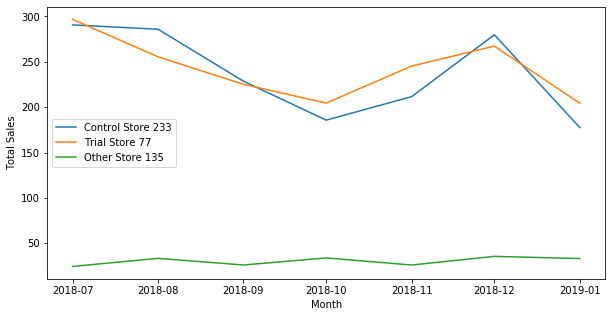

In [110]:
plt.figure(figsize=(10,5))
plt.plot(combinePlot)
plt.legend(['Control Store 233', 'Trial Store 77', 'Other Store 135'])
plt.xlabel('Month')
plt.ylabel('Total Sales')

In [111]:

control233 = metricsTable[(metricsTable['storeNumber']==233)&(metricsTable['transactionMonth']<dt.datetime(2019,2,1))]\
['noCustomers'].reset_index(drop=True)
trial77 = metricsTable[(metricsTable['storeNumber']==77)&(metricsTable['transactionMonth']<dt.datetime(2019,2,1))]\
['noCustomers'].reset_index(drop=True)

otherstore135 = metricsTable[(metricsTable['storeNumber']==135)&(metricsTable['transactionMonth']<dt.datetime(2019,2,1))]\
['noCustomers'].reset_index(drop=True)

combinePlot = pd.concat([control233,trial77,otherstore135], axis=1).set_index(metricsTable.loc[0:6,'transactionMonth'])
combinePlot.columns = ['controlStore','trialStore', 'otherStore']


Text(0, 0.5, 'Total Customers')

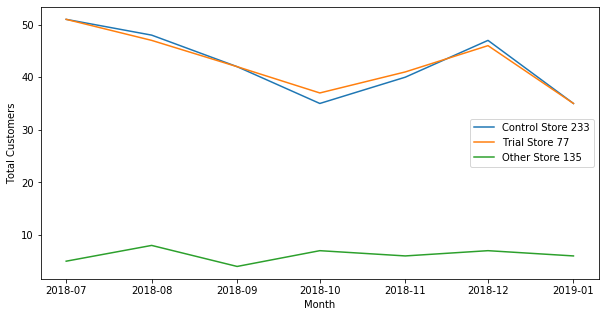

In [112]:
plt.figure(figsize=(10,5))
plt.plot(combinePlot)
plt.legend(['Control Store 233', 'Trial Store 77', 'Other Store 135'])
plt.xlabel('Month')
plt.ylabel('Total Customers')

The two graphs above shows that the Control and Trial store has similar trends in total sales and number of customers during pre-trial period. 

Trial period goes from the start of February 2019 to April 2019. We will scale control store to similar level in the pre-trial period.

In [113]:
#use sum of total sales for trial store, divided by sum of total sales for control store.
pretrialdate = dt.datetime(2019,2,1)
trialSales = metricsTable[(metricsTable['storeNumber']==77)&(metricsTable['transactionMonth']<pretrialdate)]['totaSales'].sum()
controlSales= metricsTable[(metricsTable['storeNumber']==233)&(metricsTable['transactionMonth']<pretrialdate)]['totaSales'].sum()
scalingFactor77 = trialSales/controlSales

In [114]:
scalingFactor77 

1.023617303289553

Scailing factor for control store is 1.024. The scailing factor will be applied to total sales for control store 233.

In [115]:
#create a new table for scaled values for control store
scaledControlSales = metricsTable[metricsTable['storeNumber']==233][['yearMonth','totaSales']].reset_index(drop=True)
scaledControlSales.rename(columns={'totaSales':'controlStore233'}, inplace=True)
scaledControlSales['controlStore233'] = scaledControlSales['controlStore233']*scalingFactor77
scaledControlSales['trialStore77'] =  metricsTable[metricsTable['storeNumber']==77]['totaSales'].reset_index(drop=True)

In [116]:
#calculate the absolute percentage difference between the 2 stores (trial-control)/control
scaledControlSales['percentageDiff']= abs(scaledControlSales['trialStore77']-scaledControlSales['controlStore233'])/\
                                      scaledControlSales['controlStore233']

In [117]:
scaledControlSales

,yearMonth,controlStore233,trialStore77,percentageDiff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602
3,201810,190.085733,204.5,0.075830
4,201811,216.597421,245.3,0.132516
5,201812,286.408121,267.3,0.066716
6,201901,181.692071,204.4,0.124980
7,201902,249.762622,235.0,0.059107
8,201903,203.802205,278.5,0.366521
9,201904,162.345704,263.5,0.623080


In [118]:
#standard deviation for trial period on percentage difference
st_dev = np.std(scaledControlSales.loc[0:7,'percentageDiff']) 

In [119]:
st_dev

0.043853169162891614

In [120]:
#degree of freedom is 7-1=6 2018 July to 2019 January
dof=6

In [121]:
# 95th percentile of the t-distribution with 6 degree of freedom
stats.t.isf(0.05,dof)

1.9431802803927818

In [122]:
#calculate the test statistic using (x - u)/standard deviation
#null hypothesis is the difference between trial and control store is 0
scaledControlSales['tValue'] = (scaledControlSales['percentageDiff']-0)/st_dev

In [123]:
scaledControlSales

,yearMonth,controlStore233,trialStore77,percentageDiff,tValue
0,201807,297.565550,296.8,0.002573,0.058666
1,201808,292.652187,255.5,0.126950,2.894887
2,201809,233.998916,225.2,0.037602,0.857461
3,201810,190.085733,204.5,0.075830,1.729187
4,201811,216.597421,245.3,0.132516,3.021806
5,201812,286.408121,267.3,0.066716,1.521359
6,201901,181.692071,204.4,0.124980,2.849972
7,201902,249.762622,235.0,0.059107,1.347830
8,201903,203.802205,278.5,0.366521,8.357914
9,201904,162.345704,263.5,0.623080,14.208314


t-statistic for trial period Feb 2019 is smaller than t value, therefore insufficient evidence to conclude the increase is statistically significant. However t-statistic for March and April 2019 is much larger than t value, the increase sales in trial store during these 2 months are statistically significant. 

In [124]:
#create a new table for visualization of sales for control store, trial, store, and control store's 95th percentile value of sales
pastSales = pd.DataFrame(scaledControlSales[['yearMonth','trialStore77','controlStore233']])

#calculate the 95th and 5th percentile value of the control store using: 
# totSales * (1 + stdDev * 2) and totSales * (1 - stdDev * 2)
pastSales['control95%Confidence'] = pastSales['controlStore233']*(1+st_dev*2)
pastSales['control5%Confidence'] = pastSales['controlStore233']*(1-st_dev*2)


In [125]:
#convert to datetime for ploting purpose
pastSales.index = pd.to_datetime(scaledControlSales['yearMonth'], format='%Y%m')

In [126]:
pastSales.drop(columns= 'yearMonth', inplace=True)

Text(2019-04-01, 263.5, 'April')

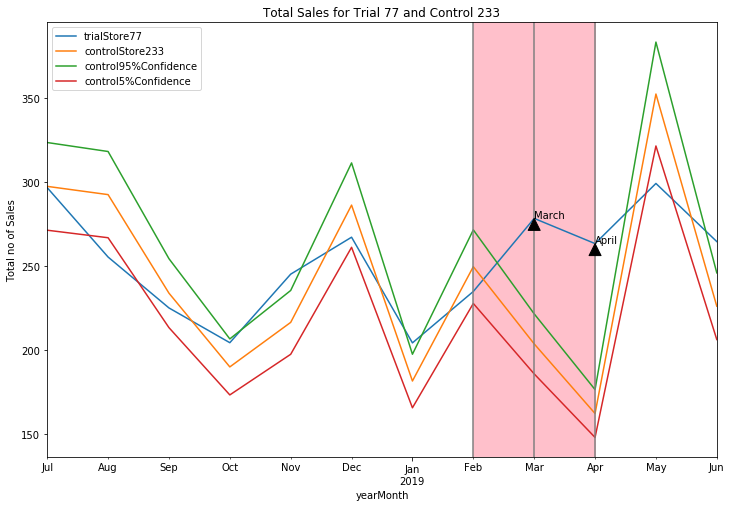

In [127]:
pastSales.plot(figsize=(12,8))
plt.axvspan('2019-02-01','2019-04-01', color='pink')
plt.title('Total Sales for Trial 77 and Control 233')
plt.ylabel('Total no of Sales')
[plt.axvline(x, color='grey') for x in ['2019-02-01','2019-03-01','2019-04-01']]
plt.annotate('March', xy=('2019-03-01',278.5), arrowprops={'facecolor':'black'})
plt.annotate('April', xy=('2019-04-01',263.5), arrowprops={'facecolor':'black'})

Shaded area indicates the total sales during the trial period. Total sales for trial store 77 in March and April are significantly higher than the control store. As the value lies outside the 5% and 95% confidence interval of the Control Store.

In [128]:
pastSales

,trialStore77,controlStore233,control95%Confidence,control5%Confidence
yearMonth,,,,
2018-07-01,296.8,297.565550,323.663935,271.467165
2018-08-01,255.5,292.652187,318.319639,266.984735
2018-09-01,225.2,233.998916,254.522104,213.475727
2018-10-01,204.5,190.085733,206.757457,173.414010
2018-11-01,245.3,216.597421,235.594388,197.600455
2018-12-01,267.3,286.408121,311.527929,261.288314
2019-01-01,204.4,181.692071,197.627618,165.756525
2019-02-01,235.0,249.762622,271.668387,227.856857
2019-03-01,278.5,203.802205,221.676950,185.927460


In [129]:
#calculate scailing factor for total number of customers for control 233 and trial 77. 
pretrialdate = dt.datetime(2019,2,1)
trialCus = metricsTable[(metricsTable['storeNumber']==77)&(metricsTable['transactionMonth']<pretrialdate)]['noCustomers'].sum()
controlCus= metricsTable[(metricsTable['storeNumber']==233)&(metricsTable['transactionMonth']<pretrialdate)]['noCustomers'].sum()
scalingFactorCus77 = trialCus/controlCus
scalingFactorCus77

1.0033557046979866

In [130]:
scaledControlCus = metricsTable[metricsTable['storeNumber']==233][['yearMonth','noCustomers']].reset_index(drop=True)
scaledControlCus.rename(columns={'noCustomers':'controlStore233'}, inplace=True)
scaledControlCus['controlStore233'] = scaledControlCus['controlStore233']*scalingFactorCus77
scaledControlCus['trialStore77'] =  metricsTable[metricsTable['storeNumber']==77]['noCustomers'].reset_index(drop=True)
scaledControlCus

,yearMonth,controlStore233,trialStore77
0,201807,51.171141,51
1,201808,48.161074,47
2,201809,42.140940,42
3,201810,35.117450,37
4,201811,40.134228,41
5,201812,47.157718,46
6,201901,35.117450,35
7,201902,45.151007,45
8,201903,40.134228,50
9,201904,30.100671,47


In [131]:
#calculated the absolute percentage difference for total number of customers using (trial-control)/control
scaledControlCus['percentageDiff']= abs(scaledControlCus['trialStore77']-scaledControlCus['controlStore233'])/\
                                      scaledControlCus['controlStore233']

In [132]:
#calculate standard deviation for trial period on the percentage difference
st_dev2=np.std(scaledControlCus.loc[0:7,'percentageDiff'])
dof=6

#create new column for t statistic using (x-u)/standard deviation
scaledControlCus['tValue'] = (scaledControlCus['percentageDiff']-0)/st_dev2
scaledControlCus

,yearMonth,controlStore233,trialStore77,percentageDiff,tValue
0,201807,51.171141,51,0.003344,0.201031
1,201808,48.161074,47,0.024108,1.449097
2,201809,42.140940,42,0.003344,0.201031
3,201810,35.117450,37,0.053607,3.222236
4,201811,40.134228,41,0.021572,1.296648
5,201812,47.157718,46,0.024550,1.475651
6,201901,35.117450,35,0.003344,0.201031
7,201902,45.151007,45,0.003344,0.201031
8,201903,40.134228,50,0.245819,14.775762
9,201904,30.100671,47,0.561427,33.746365


Just to recall the 95th percentile of t-distribution is 1.9432. Therefore we can conclude that the change in trial months March and April is statistically significant. 
<br>
Lets confirm if the change is significate using a graph.

In [133]:
#create a new table for visualization
pastCustomers = pd.DataFrame(scaledControlCus[['yearMonth','trialStore77','controlStore233']])

#calculate the 95th and 5th percentile value of the control store using: 
# totSales * (1 + stdDev * 2) and totSales * (1 - stdDev * 2)
pastCustomers['control95%Confidence'] = pastCustomers['controlStore233']*(1+st_dev*2)
pastCustomers['control5%Confidence'] = pastCustomers['controlStore233']*(1-st_dev*2)
pastCustomers.set_index(pd.to_datetime(pastCustomers['yearMonth'], format='%Y%m'), inplace=True)
pastCustomers.drop(columns='yearMonth', inplace=True)                        

In [134]:
pastCustomers

,trialStore77,controlStore233,control95%Confidence,control5%Confidence
yearMonth,,,,
2018-07-01,51,51.171141,55.659174,46.683108
2018-08-01,47,48.161074,52.385105,43.937042
2018-09-01,42,42.140940,45.836967,38.444912
2018-10-01,37,35.117450,38.197473,32.037427
2018-11-01,41,40.134228,43.654254,36.614202
2018-12-01,46,47.157718,51.293749,43.021687
2019-01-01,35,35.117450,38.197473,32.037427
2019-02-01,45,45.151007,49.111036,41.190977
2019-03-01,50,40.134228,43.654254,36.614202


Text(2019-04-01, 47, 'April')

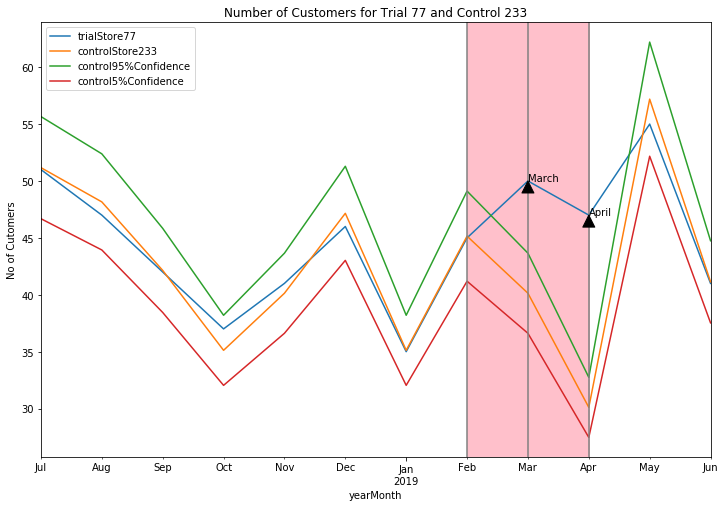

In [135]:
pastCustomers.plot(figsize=(12,8))
plt.legend()
plt.title('Number of Customers for Trial 77 and Control 233')
plt.ylabel('No of Cutomers')
[plt.axvline(x, color='grey')for x in ['2019-02-01','2019-03-01','2019-04-01']]
plt.axvspan('2019-02-01','2019-04-01', color='pink')
plt.annotate('March', xy=('2019-03-01',50), arrowprops={'facecolor':'black'})
plt.annotate('April', xy=('2019-04-01',47), arrowprops={'facecolor':'black'})

Shaded area indicates the total number of customers during the trial period. Total number of customers for trial store 77 in March and April lies outside the 5% and 95% confidence interval of the Control Store. Therefore we can conclude that the difference is statistically significant. 

## Define a few functions to simplify the analysis for trial stores 86 and 88

In [136]:
#Function to calculate scailing factor to scale control group
#use sum of total sales for trial store, divided by sum of total sales for control store.
def scalingFactor(data, metrics, controlS, trialS):
    trialSales = data[data['storeNumber']==trialS][metrics].sum()
    controlSales = data[data['storeNumber']==controlS][metrics].sum()
    sf = trialSales/controlSales
    return sf

#Function to generate table with percentage difference and t-Value
def scaledTable(data, metrics, controlS, trialS, sf):
    table =data[data['storeNumber']==controlS][['yearMonth',metrics]].reset_index(drop=True)
    table[metrics] = table[metrics]*sf
    table['trialStore'] = data[data['storeNumber']==trialS][metrics].reset_index(drop=True)
    table['percentageDiff'] = abs(table['trialStore']-table[metrics])/table[metrics]
    st_dev=np.std(table.loc[0:7,'percentageDiff'])
    table['tValue'] = (table['percentageDiff']-0)/st_dev
    table.rename(columns= {metrics:'controlStore'},inplace=True)
    return table

#Function to calculate the 95% and 5% confidence interval of control store
def confidenceInterval(data):
    table = pd.DataFrame(data[['yearMonth','controlStore','trialStore']])
    st_dev= np.std(data.loc[0:7,'percentageDiff'])
    table['control95%Confidence']= table['controlStore']*(1+st_dev*2)
    table['control5%Confidence']= table['controlStore']*(1-st_dev*2)
    table.set_index(pd.to_datetime(table['yearMonth'], format='%Y%m'), inplace=True)
    table.drop(columns='yearMonth', inplace=True)
    return table
 
#function to visualize/plot the confidence intervals for control store and trial store   
def graph(data,control, trial, metric, month=[]):
    data.plot(figsize=(12,8))
    plt.legend()
    plt.title(f'Total {metric} for Trial {trial} and Control {control}')
    [plt.axvline(x, color='grey')for x in ['2019-02-01','2019-03-01','2019-04-01']]
    plt.axvspan('2019-02-01','2019-04-01', color='pink')
    if month:
        for i in month:
            i = pd.to_datetime(i)
            m = i.strftime('%B')
            y = data.loc[i,'trialStore']
            plt.annotate(m, xy=(i,y), arrowprops={'facecolor':'black'})

## Trial store 86
Repeat a steps for trial store 86 to find a control store.
Calculate correlation and magnitude distance for the following metrics:
* total sales 
* number of customers


#### Step 1: find control store

In [137]:
metricsTablePreTrial

,storeNumber,yearMonth,totaSales,noCustomers,noTransactions
0,1,201807,206.9,49,1.061224
1,1,201808,176.1,42,1.023810
2,1,201809,278.8,59,1.050847
3,1,201810,188.1,44,1.022727
4,1,201811,192.6,46,1.021739
...,...,...,...,...,...
3110,272,201809,304.7,32,1.125000
3111,272,201810,430.6,44,1.136364
3112,272,201811,376.2,41,1.097561
3113,272,201812,403.9,47,1.000000


In [138]:
#caculate correlation, magnitude distance for total sales
magSales86 = calculateMagnitudeDistance(metricsTablePreTrial, 86, 'totaSales')
corSales86 = calculateCorrelation(metricsTablePreTrial, 86, 'totaSales')
combine = corSales86.merge(magSales86, how='inner', on=['store1','store2'])

#calculate a simple average on correlation and magnitude scores
combine['scoreNSales'] = 0.5*combine['corrMeasure']+0.5*combine['magnitudeDistance']

In [139]:
combine

,store1,store2,corrMeasure,magnitudeDistance,scoreNSales
0,86,1,0.445632,0.488334,0.466983
1,86,2,-0.403835,0.321131,-0.041352
2,86,3,-0.261284,0.507515,0.123116
3,86,4,-0.039035,0.635654,0.298309
4,86,5,0.235159,0.579835,0.407497
...,...,...,...,...,...
255,86,268,-0.452182,0.291930,-0.080126
256,86,269,0.697055,0.480267,0.588661
257,86,270,-0.730679,0.517014,-0.106832
258,86,271,0.527637,0.565665,0.546651


In [140]:
#caculate correlation, magnitude distance for total customers
corCustomer86 = calculateCorrelation(metricsTablePreTrial, 86, 'noCustomers')
magCustomer86 = calculateMagnitudeDistance(metricsTablePreTrial, 86, 'noCustomers')

#calculate a simple average on correlation and magnitude scores for number of customers
combine['scoreNCust'] = 0.5*corCustomer86['corrMeasure']+0.5*magCustomer86['magnitudeDistance']

#calculate finalControlScore using this fomula: scoreNSales * 0.5 + scoreNCust * 0.5
scoreControl = combine.drop(columns=['corrMeasure', 'magnitudeDistance'])
scoreControl['finalControlScore'] = scoreControl['scoreNSales']*0.5 + scoreControl['scoreNCust']*0.5
scoreControl

#find the store with the highest finalControlScore
scoreControl.sort_values(by='finalControlScore', ascending=False).head(1)

,store1,store2,scoreNSales,scoreNCust,finalControlScore
147,86,155,0.808106,0.733343,0.770724


Store 155 will be the control store for trial store 86.

Let's check visually if the drivers are indeed similar in the period before the trial between the Trial and Control Store. A randomly selected store (other store) will also be plotted for comparison.

#### Step 2: visually compare the stores.

In [141]:
#randomly select a store number for other store
otherstoreNo = metricsTable['storeNumber'].sample(1, random_state = 2)
otherstoreNo

1463    129
Name: storeNumber, dtype: int64

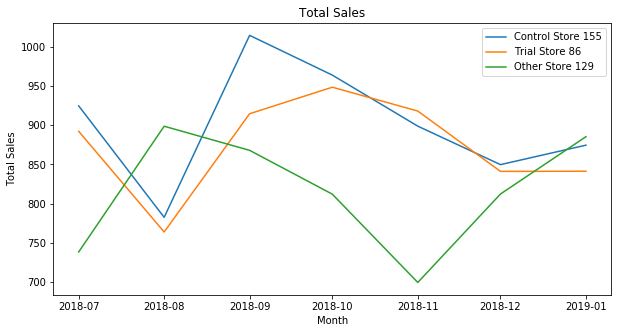

In [142]:
#filter the 3 store's total sales data prior to trial period
control155 = metricsTable[(metricsTable['storeNumber']==155)&(metricsTable['transactionMonth']<pretrialdate)]\
['totaSales'].reset_index(drop=True)
trial86 = metricsTable[(metricsTable['storeNumber']==86)&(metricsTable['transactionMonth']<pretrialdate)]\
['totaSales'].reset_index(drop=True)
otherstore129 = metricsTable[(metricsTable['storeNumber']==129)&(metricsTable['transactionMonth']<pretrialdate)]\
['totaSales'].reset_index(drop=True)

#create new table with 3 store's total sales.
combinePlot = pd.concat([control155,trial86,otherstore129], axis=1).set_index(metricsTable.loc[0:6,'transactionMonth'])
combinePlot.columns = ['controlStore','trialStore', 'otherStore']

#ploting the total sales for the 3 stores.
plt.figure(figsize=(10,5))
plt.plot(combinePlot)
plt.legend(['Control Store 155', 'Trial Store 86', 'Other Store 129'])
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales')
plt.show()


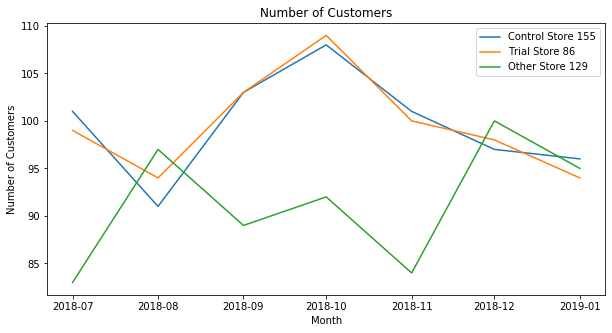

In [143]:
#filter the 3 store's number of customer data prior to trial period
control155 = metricsTable[(metricsTable['storeNumber']==155)&(metricsTable['transactionMonth']<pretrialdate)]\
['noCustomers'].reset_index(drop=True)
trial86 = metricsTable[(metricsTable['storeNumber']==86)&(metricsTable['transactionMonth']<pretrialdate)]\
['noCustomers'].reset_index(drop=True)
otherstore129 = metricsTable[(metricsTable['storeNumber']==129)&(metricsTable['transactionMonth']<pretrialdate)]\
['noCustomers'].reset_index(drop=True)

#create new table with 3 store's total sales.
combinePlot = pd.concat([control155,trial86,otherstore129], axis=1).set_index(metricsTable.loc[0:6,'transactionMonth'])
combinePlot.columns = ['controlStore','trialStore', 'otherStore']

#ploting the total sales for the 3 stores.
plt.figure(figsize=(10,5))
plt.plot(combinePlot)
plt.legend(['Control Store 155', 'Trial Store 86', 'Other Store 129'])
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.title('Number of Customers')
plt.show()

#### Comparing Total Sales for trial store 86 and control store 155

In [144]:
scalingFactorS = scalingFactor(metricsTablePreTrial, 'totaSales', 155, 86)
scaledControlSales = scaledTable(metricsTable, 'totaSales', 155, 86, scalingFactorS)
scaledControlSales

,yearMonth,controlStore,trialStore,percentageDiff,tValue
0,201807,896.922236,892.20,0.005265,0.214096
1,201808,759.269991,764.05,0.006296,0.256004
2,201809,984.034086,914.60,0.070561,2.869311
3,201810,934.948790,948.40,0.014387,0.585044
4,201811,871.894555,918.00,0.052880,2.150321
5,201812,824.361363,841.20,0.020426,0.830624
6,201901,848.418979,841.40,0.008273,0.336417
7,201902,864.522060,913.20,0.056306,2.289660
8,201903,780.320405,1026.80,0.315870,12.844671
9,201904,819.317024,848.20,0.035253,1.433524


In [145]:
pastCustomerS = confidenceInterval(scaledControlSales)
pastCustomerS

,controlStore,trialStore,control95%Confidence,control5%Confidence
yearMonth,,,,
2018-07-01,896.922236,892.20,941.035562,852.808910
2018-08-01,759.269991,764.05,796.613167,721.926815
2018-09-01,984.034086,914.60,1032.431835,935.636338
2018-10-01,934.948790,948.40,980.932376,888.965203
2018-11-01,871.894555,918.00,914.776945,829.012165
2018-12-01,824.361363,841.20,864.905928,783.816798
2019-01-01,848.418979,841.40,890.146769,806.691188
2019-02-01,864.522060,913.20,907.041848,822.002272
2019-03-01,780.320405,1026.80,818.698904,741.941907


From the 2 tables above, total sales for trial store lies outside the confidence intervals for Feb and March during trial period. We therefore have sufficient evidence to conclude the difference between trial and control store are statistically significant. 

#### Comparing number of customers for trial store 86 and control store 155

In [146]:
scalingFactorC = scalingFactor(metricsTablePreTrial, 'noCustomers', 155, 86)
scaledControlCus = scaledTable(metricsTable, 'noCustomers', 155, 86, scalingFactorC)
scaledControlCus

,yearMonth,controlStore,trialStore,percentageDiff,tValue
0,201807,101.0,99,0.019802,0.520444
1,201808,91.0,94,0.032967,0.866453
2,201809,103.0,103,0.000000,0.000000
3,201810,108.0,109,0.009259,0.243356
4,201811,101.0,100,0.009901,0.260222
5,201812,97.0,98,0.010309,0.270953
6,201901,96.0,94,0.020833,0.547550
7,201902,95.0,107,0.126316,3.319884
8,201903,94.0,115,0.223404,5.871603
9,201904,99.0,105,0.060606,1.592874


In [147]:
pastCustomerC = confidenceInterval(scaledControlCus)
pastCustomerC

,controlStore,trialStore,control95%Confidence,control5%Confidence
yearMonth,,,,
2018-07-01,101.0,99,108.685747,93.314253
2018-08-01,91.0,94,97.924782,84.075218
2018-09-01,103.0,103,110.837940,95.162060
2018-10-01,108.0,109,116.218423,99.781577
2018-11-01,101.0,100,108.685747,93.314253
2018-12-01,97.0,98,104.381361,89.618639
2019-01-01,96.0,94,103.305265,88.694735
2019-02-01,95.0,107,102.229168,87.770832
2019-03-01,94.0,115,101.153072,86.846928


Same result as total sales, number of customers for trial store during trial months Feb and March lies outside the confidence intervals of control store during the same period. We therefore have sufficient evidence to conclude the difference between trial and control store are statistically significant. 

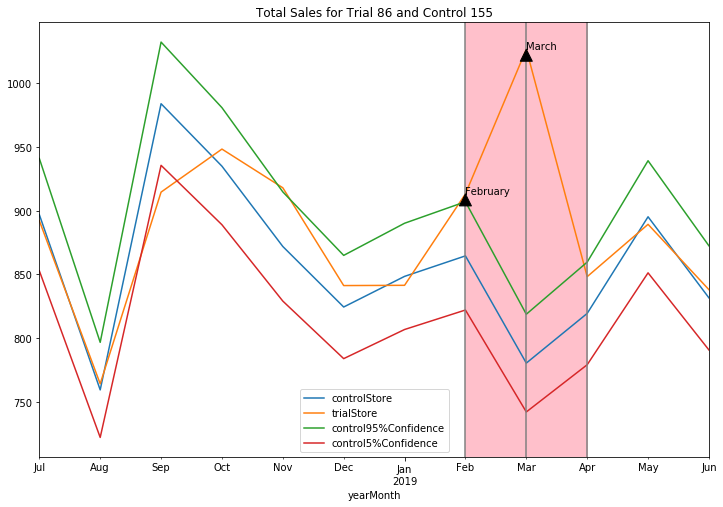

In [148]:
graph(pastCustomerS,155, 86, 'Sales', month=['2019-02-01','2019-03-01'])

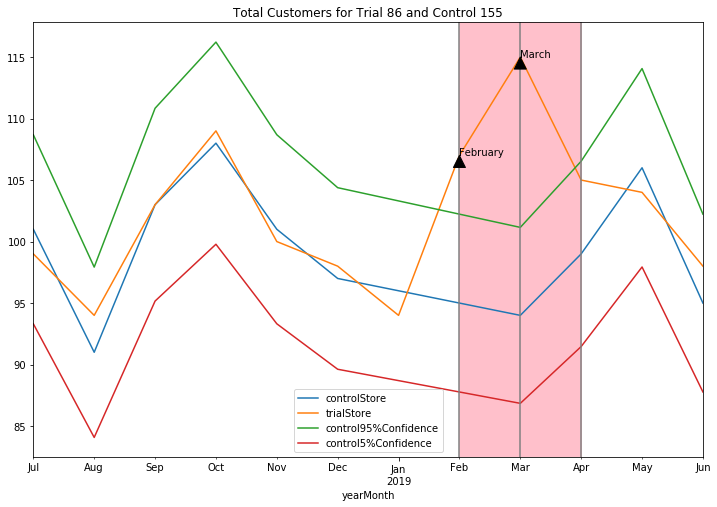

In [149]:
graph(pastCustomerC,155, 86, 'Customers', month=['2019-02-01','2019-03-01'])

As shown in the two graphs above, total sales and number of customers for trial store during trial period Feb and March, lies outside of the 95% and 5% confidence interval of the control store. We can therefore conclude that the difference is statistically significant. 

## Trial store 88
Repeat a steps for trial store 88 to find a control store. Calculate correlation and magnitude distance for the following metrics:

total sales
number of customers
Step 1: find control store

In [150]:
#caculate correlation, magnitude distance for total sales
magSales88 = calculateMagnitudeDistance(metricsTablePreTrial, 88, 'totaSales')
corSales88 = calculateCorrelation(metricsTablePreTrial, 88, 'totaSales')
combine = corSales88.merge(magSales88, how='inner', on=['store1','store2'])

#calculate a simple average on correlation and magnitude scores
combine['scoreNSales'] = 0.5*combine['corrMeasure']+0.5*combine['magnitudeDistance']
combine

,store1,store2,corrMeasure,magnitudeDistance,scoreNSales
0,88,1,0.813636,0.548959,0.681297
1,88,2,-0.067927,0.541212,0.236643
2,88,3,-0.507847,0.458109,-0.024869
3,88,4,-0.745566,0.484447,-0.130559
4,88,5,0.190330,0.496409,0.343370
...,...,...,...,...,...
255,88,268,-0.021429,0.522847,0.250709
256,88,269,-0.172578,0.564856,0.196139
257,88,270,-0.723272,0.513329,-0.104971
258,88,271,-0.103037,0.429220,0.163091


In [151]:
#caculate correlation, magnitude distance for total customers
corCustomer88 = calculateCorrelation(metricsTablePreTrial, 88, 'noCustomers')
magCustomer88 = calculateMagnitudeDistance(metricsTablePreTrial, 88, 'noCustomers')

#calculate a simple average on correlation and magnitude scores for number of customers
combine['scoreNCust'] = 0.5*corCustomer88['corrMeasure']+0.5*magCustomer88['magnitudeDistance']

#calculate finalControlScore using this fomula: scoreNSales * 0.5 + scoreNCust * 0.5
scoreControl = combine.drop(columns=['corrMeasure', 'magnitudeDistance'])
scoreControl['finalControlScore'] = scoreControl['scoreNSales']*0.5 + scoreControl['scoreNCust']*0.5
scoreControl

#find the store with the highest finalControlScore
scoreControl.sort_values(by='finalControlScore', ascending=False).head(3)

,store1,store2,scoreNSales,scoreNCust,finalControlScore
170,88,178,0.650803,0.707828,0.679316
12,88,14,0.646064,0.685774,0.665919
126,88,134,0.775084,0.540154,0.657619


Store 178 has the highest final control score, lets try to visualize the total sale and customers, and confirm if the trends are similar. 

In [152]:
#randomly select a store number for other store
otherstoreNoo = metricsTable['storeNumber'].sample(1, random_state = 3)
otherstoreNoo

1008    90
Name: storeNumber, dtype: int64

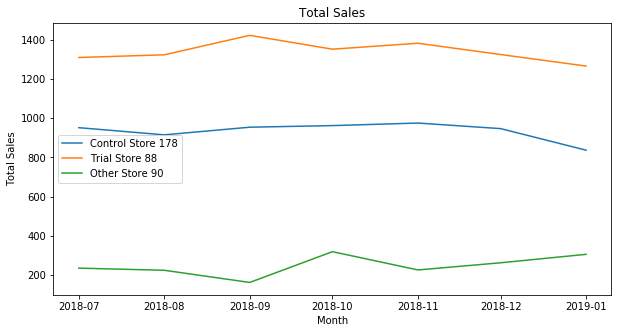

In [153]:
#filter the 3 store's total sales data prior to trial period
control178 = metricsTable[(metricsTable['storeNumber']==178)&(metricsTable['transactionMonth']<pretrialdate)]\
['totaSales'].reset_index(drop=True)
trial88 = metricsTable[(metricsTable['storeNumber']==88)&(metricsTable['transactionMonth']<pretrialdate)]\
['totaSales'].reset_index(drop=True)
otherstore90 = metricsTable[(metricsTable['storeNumber']==90)&(metricsTable['transactionMonth']<pretrialdate)]\
['totaSales'].reset_index(drop=True)

#create new table with 3 store's total sales.
combinePlot = pd.concat([control178,trial88,otherstore90], axis=1).set_index(metricsTable.loc[0:6,'transactionMonth'])
combinePlot.columns = ['controlStore','trialStore', 'otherStore']

#ploting the total sales for the 3 stores.
plt.figure(figsize=(10,5))
plt.plot(combinePlot)
plt.legend(['Control Store 178', 'Trial Store 88', 'Other Store 90'])
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales')
plt.show()


The trends are relatively similar, however control store's value are a lot lower, therefore scailing is needed. 
<br>
Lets also visualize the number of customers before we perform scailing to control store. 

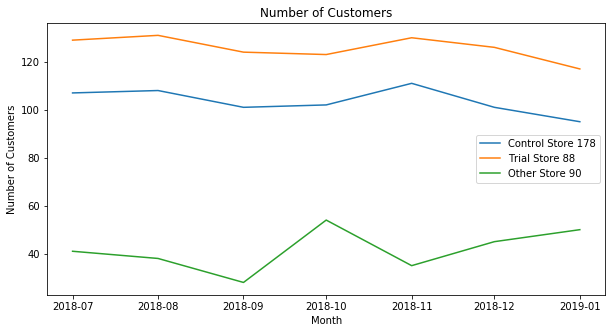

In [154]:
#filter the 3 store's number of customer data prior to trial period
control178 = metricsTable[(metricsTable['storeNumber']==178)&(metricsTable['transactionMonth']<pretrialdate)]\
['noCustomers'].reset_index(drop=True)
trial88 = metricsTable[(metricsTable['storeNumber']==88)&(metricsTable['transactionMonth']<pretrialdate)]\
['noCustomers'].reset_index(drop=True)
otherstore90 = metricsTable[(metricsTable['storeNumber']==90)&(metricsTable['transactionMonth']<pretrialdate)]\
['noCustomers'].reset_index(drop=True)

#create new table with 3 store's number of customers
combinePlot = pd.concat([control178,trial88,otherstore90], axis=1).set_index(metricsTable.loc[0:6,'transactionMonth'])
combinePlot.columns = ['controlStore','trialStore', 'otherStore']

#ploting the number of customers for the 3 stores.
plt.figure(figsize=(10,5))
plt.plot(combinePlot)
plt.legend(['Control Store 178', 'Trial Store 88', 'Other Store 90'])
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.title('Number of Customers')
plt.show()

Similar trends in number of customers between trial and control store, lets scale up the control store and find the percentage difference and t statistic. 

#### Comparing total sales for control stor 178 and trial store 88

In [155]:
#using previous defined function 
scalingFactorS = scalingFactor(metricsTablePreTrial, 'totaSales', 178, 88)
scaledControlSales = scaledTable(metricsTable, 'totaSales', 178, 88, scalingFactorS)
scaledControlSales

,yearMonth,controlStore,trialStore,percentageDiff,tValue
0,201807,1364.991550,1310.00,0.040287,1.172207
1,201808,1312.657315,1323.80,0.008489,0.246988
2,201809,1368.432705,1423.00,0.039876,1.160238
3,201810,1380.189985,1352.40,0.020135,0.585852
4,201811,1398.829576,1382.80,0.011459,0.333423
5,201812,1358.109240,1325.20,0.024232,0.705052
6,201901,1200.389628,1266.40,0.054991,1.600030
7,201902,1561.137395,1370.20,0.122307,3.558673
8,201903,1432.094076,1477.20,0.031496,0.916432
9,201904,1519.556770,1439.40,0.052750,1.534834


Assesing the t statistic, only t-value for trial period Feb, is greater than 95th percentile of t-distribution. The difference for March and April is not statistically significant. Lets visualize this.

In [156]:
pastCustomerS = confidenceInterval(scaledControlSales)
pastCustomerS

,controlStore,trialStore,control95%Confidence,control5%Confidence
yearMonth,,,,
2018-07-01,1364.991550,1310.00,1458.817241,1271.165859
2018-08-01,1312.657315,1323.80,1402.885698,1222.428933
2018-09-01,1368.432705,1423.00,1462.494932,1274.370479
2018-10-01,1380.189985,1352.40,1475.060374,1285.319597
2018-11-01,1398.829576,1382.80,1494.981198,1302.677954
2018-12-01,1358.109240,1325.20,1451.461860,1264.756620
2019-01-01,1200.389628,1266.40,1282.901044,1117.878211
2019-02-01,1561.137395,1370.20,1668.445601,1453.829189
2019-03-01,1432.094076,1477.20,1530.532206,1333.655946


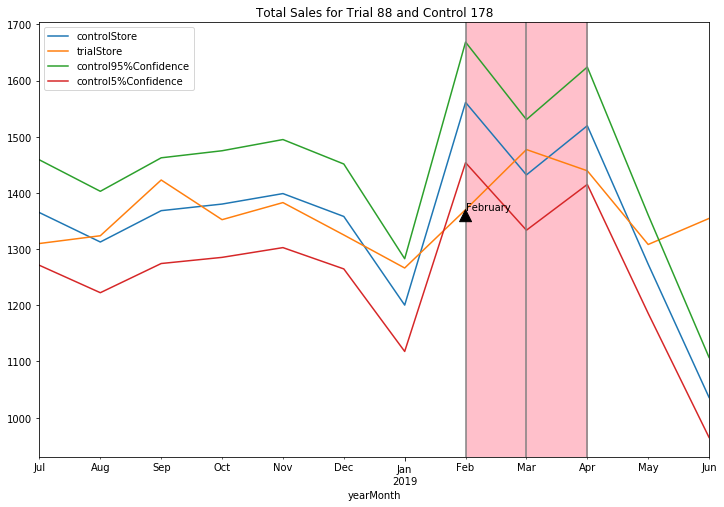

In [157]:
graph(pastCustomerS,178, 88, 'Sales', month=['2019-02-01'])

Trial store's total sales in Feb lies outside of the confidence interval of control store. The difference is statistically significant. 

#### Comparing number of customers for control store 178 and trial store 88

In [158]:
scalingFactorC = scalingFactor(metricsTablePreTrial, 'noCustomers', 178, 88)
scaledControlCus = scaledTable(metricsTable, 'noCustomers', 178, 88, scalingFactorC)
scaledControlCus

,yearMonth,controlStore,trialStore,percentageDiff,tValue
0,201807,129.875862,129,0.006744,0.457166
1,201808,131.089655,131,0.000684,0.046363
2,201809,122.593103,124,0.011476,0.777971
3,201810,123.806897,123,0.006517,0.441815
4,201811,134.731034,130,0.035115,2.380430
5,201812,122.593103,126,0.027790,1.883909
6,201901,115.310345,117,0.014653,0.993337
7,201902,129.875862,124,0.045242,3.066975
8,201903,138.372414,134,0.031599,2.142095
9,201904,142.013793,128,0.098679,6.689477


In [159]:
pastCustomerC = confidenceInterval(scaledControlCus)
pastCustomerC

,controlStore,trialStore,control95%Confidence,control5%Confidence
yearMonth,,,,
2018-07-01,129.875862,129,133.707561,126.044163
2018-08-01,131.089655,131,134.957165,127.222146
2018-09-01,122.593103,124,126.209941,118.976266
2018-10-01,123.806897,123,127.459544,120.154249
2018-11-01,134.731034,130,138.705975,130.756094
2018-12-01,122.593103,126,126.209941,118.976266
2019-01-01,115.310345,117,118.712321,111.908369
2019-02-01,129.875862,124,133.707561,126.044163
2019-03-01,138.372414,134,142.454785,134.290043


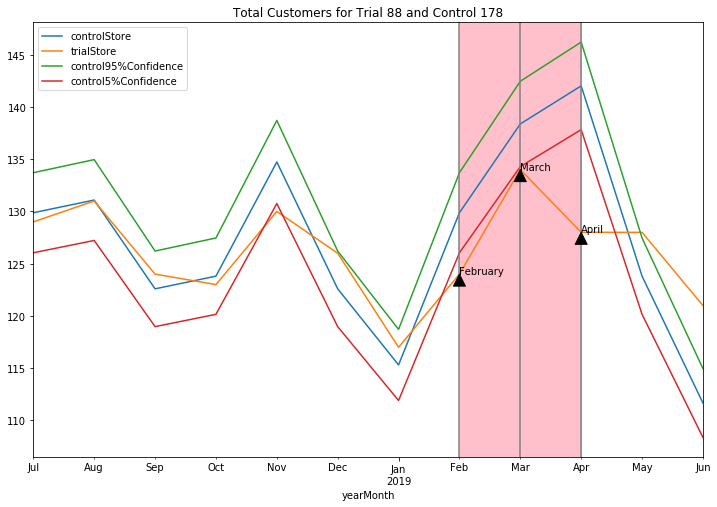

In [160]:
graph(pastCustomerC,178, 88, 'Customers', month=['2019-02-01','2019-03-01','2019-04-01'])

For number of customers, trial store's performance during trial period Feb, March and April all lies outside of the confidence interval. Inidicating a negative trial effect. 

### Lets evaluate another Control Store 237

In [161]:
scalingFactorS = scalingFactor(metricsTablePreTrial, 'totaSales', 237, 88)
scaledControlSales = scaledTable(metricsTable, 'totaSales', 237, 88, scalingFactorS)
scaledControlSales

,yearMonth,controlStore,trialStore,percentageDiff,tValue
0,201807,1450.657086,1310.00,0.096961,3.284702
1,201808,1369.931485,1323.80,0.033674,1.140769
2,201809,1324.260425,1423.00,0.074562,2.525905
3,201810,1350.401097,1352.40,0.001480,0.050145
4,201811,1399.777923,1382.80,0.012129,0.410889
5,201812,1266.971288,1325.20,0.045959,1.556932
6,201901,1221.600696,1266.40,0.036673,1.242342
7,201902,1406.989143,1370.20,0.026147,0.885784
8,201903,1210.082775,1477.20,0.220743,7.478008
9,201904,1206.477165,1439.40,0.193060,6.540216


In [163]:
pastCustomerS = confidenceInterval(scaledControlSales)
pastCustomerS

,controlStore,trialStore,control95%Confidence,control5%Confidence
yearMonth,,,,
2018-07-01,1450.657086,1310.00,1536.300829,1365.013344
2018-08-01,1369.931485,1323.80,1450.809358,1289.053612
2018-09-01,1324.260425,1423.00,1402.441974,1246.078875
2018-10-01,1350.401097,1352.40,1430.125937,1270.676257
2018-11-01,1399.777923,1382.80,1482.417867,1317.137979
2018-12-01,1266.971288,1325.20,1341.770608,1192.171969
2019-01-01,1221.600696,1266.40,1293.721431,1149.479961
2019-02-01,1406.989143,1370.20,1490.054822,1323.923464
2019-03-01,1210.082775,1477.20,1281.523516,1138.642034


(0, 2000)

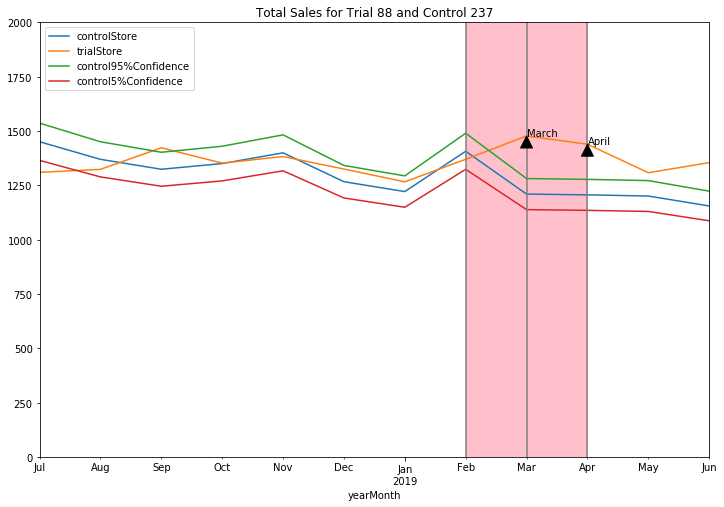

In [166]:
graph(pastCustomerS,237, 88, 'Sales', month=['2019-03-01', '2019-04-01'])
plt.ylim(0,2000)

In [167]:
scalingFactorC = scalingFactor(metricsTablePreTrial, 'noCustomers', 237, 88)
scaledControlCus = scaledTable(metricsTable, 'noCustomers', 237, 88, scalingFactorC)
scaledControlCus

,yearMonth,controlStore,trialStore,percentageDiff,tValue
0,201807,127.276836,129,0.013539,2.089771
1,201808,134.237288,131,0.024116,3.722457
2,201809,125.288136,124,0.010281,1.586986
3,201810,122.305085,123,0.005682,0.877019
4,201811,131.254237,130,0.009556,1.474986
5,201812,123.299435,126,0.021902,3.380765
6,201901,116.338983,117,0.005682,0.877019
7,201902,125.288136,124,0.010281,1.586986
8,201903,118.327684,134,0.132448,20.444113
9,201904,119.322034,128,0.072727,11.225837


In [168]:
pastCustomerC = confidenceInterval(scaledControlCus)
pastCustomerC

,controlStore,trialStore,control95%Confidence,control5%Confidence
yearMonth,,,,
2018-07-01,127.276836,129,128.925978,125.627695
2018-08-01,134.237288,131,135.976617,132.497959
2018-09-01,125.288136,124,126.911509,123.664762
2018-10-01,122.305085,123,123.889807,120.720363
2018-11-01,131.254237,130,132.954914,129.553560
2018-12-01,123.299435,126,124.897041,121.701829
2019-01-01,116.338983,117,117.846401,114.831565
2019-02-01,125.288136,124,126.911509,123.664762
2019-03-01,118.327684,134,119.860870,116.794497


(0, 150)

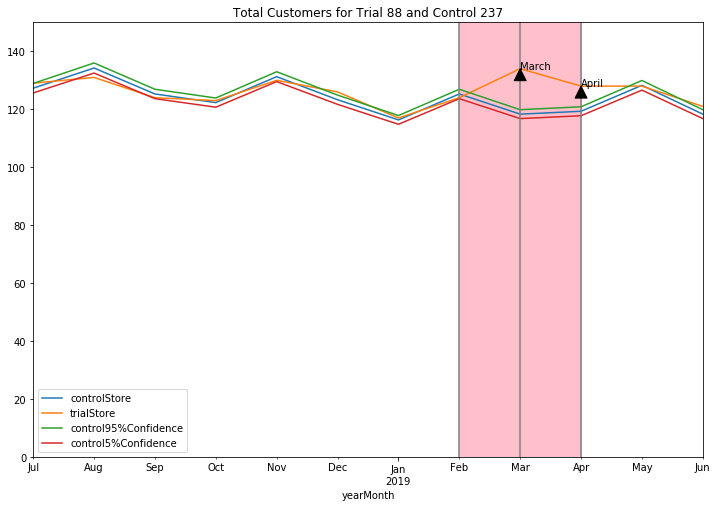

In [172]:
graph(pastCustomerC,237, 88, 'Customers', month=['2019-03-01','2019-04-01'])
plt.ylim(0,150)

Both total sales and number of customers in trial store 88 during trial period are significantly higher than the control store 237.

## Conclusion
Trial stores 77 and 86 all indicates a positive trial effect for total sales and number of customers in at least 2 out of the 3 trial months, which means the trial had a significant impact in increasing sales and number of customers. However, trial store 88 indicates a negative trial effect when comparing with control store 178, the number of customers attended trial store 88 during trial period decreased significantly. When comparing with another control store 237, both total sales and number of customers showss a significant increase.